<a href="https://colab.research.google.com/github/eshreyareddy/Clustering/blob/main/Imagebind_llm_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clustering with images using imagebind llm embeddings**

1. **Loading and Preprocessing Images**
We started by loading a set of images using Python and the librosa library. The key goal in this step was to ensure that each image was in a format suitable for processing by a neural network. This included:
Reading each image file into a numpy array.
Handling different image formats (like RGBA and grayscale) by converting all images to a consistent RGB format.
Resizing images to the required input size for the neural network (224x224 pixels in this case).
2. **Generating Image Embeddings**
Once the images were preprocessed, we used a pre-trained neural network model from TensorFlow Hub to generate embeddings for each image. This model, designed to capture complex features in images, transformed each image into a high-dimensional vector (embedding). These embeddings represent the visual content of the images in a form that's suitable for machine learning tasks.

3. **Clustering the Embeddings**
With the embeddings in hand, we applied the K-Means clustering algorithm to group the images into clusters based on the similarity of their embeddings. This unsupervised machine learning technique helped us identify natural groupings within the images.

4. **Visualizing the Clusters**
To understand how the images were grouped, we used dimensionality reduction techniques – PCA (Principal Component Analysis) and t-SNE (t-Distributed Stochastic Neighbor Embedding) – to visualize the high-dimensional embeddings in 2D space. These visualizations can reveal patterns and separations between different groups of images.

In [1]:
!pip install tensorflow tensorflow_hub scikit-learn matplotlib pandas


In [2]:
from PIL import Image
import numpy as np
import os

# Function to load images
def load_image(file_path):
    with Image.open(file_path) as img:
        return np.array(img)

# Replace these paths with the paths to your actual image files
image_files = [
    '/content/abomasnow.png',
    '/content/abra.png',
    '/content/absol.png',
    '/content/accelgor.png',
    '/content/aegislash-blade.png'
]

images = [load_image(file) for file in image_files]


In [4]:
def preprocess_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Convert RGBA to RGB by slicing to remove the alpha channel
    image = image[:,:,:3]
    image = tf.image.resize(image, (224, 224))
    image = image[tf.newaxis, ...]  # Add batch dimension
    return image


In [8]:
def preprocess_image(image):
    # Convert grayscale to RGB by duplicating the single channel across all three RGB channels
    if len(image.shape) == 2:  # Grayscale image, no channels dimension.
        image = np.stack((image,) * 3, axis=-1)
    elif image.shape[2] == 4:  # RGBA image, has an alpha channel.
        image = image[:, :, :3]  # Drop the alpha channel.

    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = image[tf.newaxis, ...]  # Add batch dimension
    return image

def get_image_embedding(image):
    preprocessed_image = preprocess_image(image)
    return model(preprocessed_image).numpy().flatten()

# Convert images to RGB and extract embeddings
embeddings = [get_image_embedding(image) for image in images]



In [10]:
import numpy as np
import tensorflow as tf

def preprocess_image(image):
    # Check if the image has an alpha channel (4th channel)
    if image.shape[-1] == 4:
        # Convert the RGBA image to RGB by dropping the alpha channel
        image = image[..., :3]

    # If the image is grayscale, convert it to RGB
    if len(image.shape) == 2 or image.shape[-1] == 1:
        image = np.stack((image,) * 3, axis=-1)

    # Normalize and resize the image
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = image[tf.newaxis, ...]
    return image

def get_image_embedding(model, image):
    preprocessed_image = preprocess_image(image)
    embedding = model(preprocessed_image)
    return embedding.numpy().flatten()

# Assuming `model` is already loaded from TensorFlow Hub
embeddings = [get_image_embedding(model, image) for image in images]


In [13]:
import tensorflow as tf
import numpy as np

# Ensure that the TensorFlow Hub model is loaded
# model = hub.load('https://tfhub.dev/google/bit/m-r50x1/1')

def preprocess_image(image):
    # Convert RGBA to RGB, if needed
    if image.shape[-1] == 4:
        image = image[..., :3]  # Drop the alpha channel, if present
    # If the image is grayscale, convert it to RGB by repeating the channels
    if len(image.shape) == 2 or image.shape[-1] == 1:
        image = np.stack((image.squeeze(),) * 3, -1)
    # Resize the image to the target size required by the model
    image = tf.image.resize(image, [224, 224])
    # Normalize the image
    image = image / 255.0
    # Expand dimensions to add the batch size
    image = tf.expand_dims(image, 0)
    return image

def get_image_embedding(image):
    # Preprocess the image
    preprocessed_image = preprocess_image(image)
    # Print the shape to confirm it's correct
    print('Preprocessed image shape:', preprocessed_image.shape)
    # Get the embeddings for the image
    embeddings = model(preprocessed_image)
    # Squeeze to remove batch dimension
    return tf.squeeze(embeddings)

# Assuming `images` is a list of numpy arrays representing the loaded images
embeddings = []
for image in images:
    # Get embeddings for each image
    embedding = get_image_embedding(image)
    embeddings.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings)
print('Embeddings have been calculated for all images.')


Preprocessed image shape: (1, 224, 224, 3)
Preprocessed image shape: (1, 224, 224, 3)
Preprocessed image shape: (1, 224, 224, 3)
Preprocessed image shape: (1, 224, 224, 3)
Preprocessed image shape: (1, 224, 224, 3)
Embeddings have been calculated for all images.


In [14]:
from sklearn.cluster import KMeans

# Assuming embeddings_array is a 2D numpy array where each row is an embedding
kmeans = KMeans(n_clusters=2, random_state=42)  # Set the number of clusters to the desired number
clusters = kmeans.fit_predict(embeddings_array)

# Print cluster assignments
print("Cluster assignments:", clusters)



Cluster assignments: [1 0 1 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


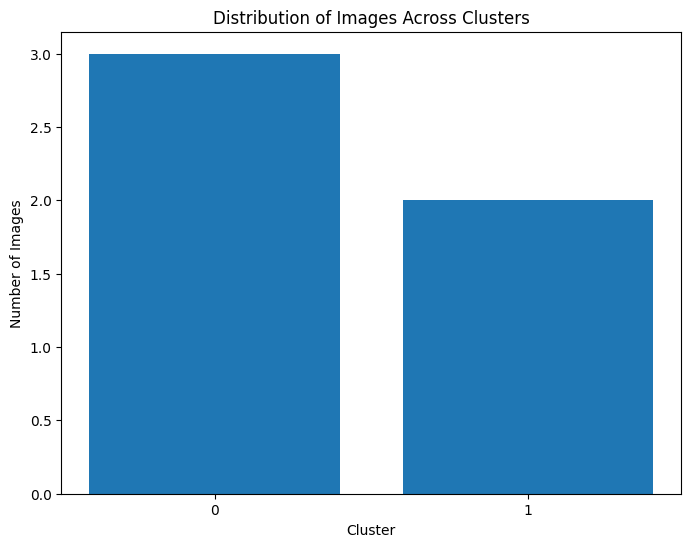

In [25]:
plt.figure(figsize=(8, 6))
plt.hist(clusters, bins=np.arange(0, np.max(clusters) + 2) - 0.5, rwidth=0.8)
plt.title('Distribution of Images Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.xticks(np.arange(np.max(clusters) + 1))
plt.show()


In [29]:
# Print the first few image paths to verify
for img_path in image_files[:5]:
    print(img_path)


/content/abomasnow.png
/content/abra.png
/content/absol.png
/content/accelgor.png
/content/aegislash-blade.png


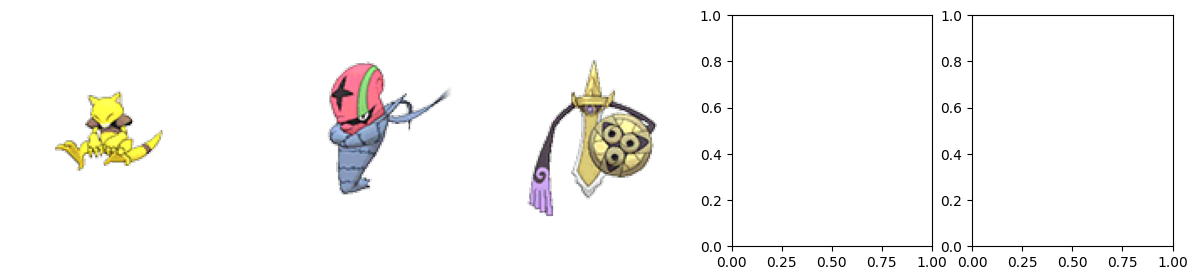

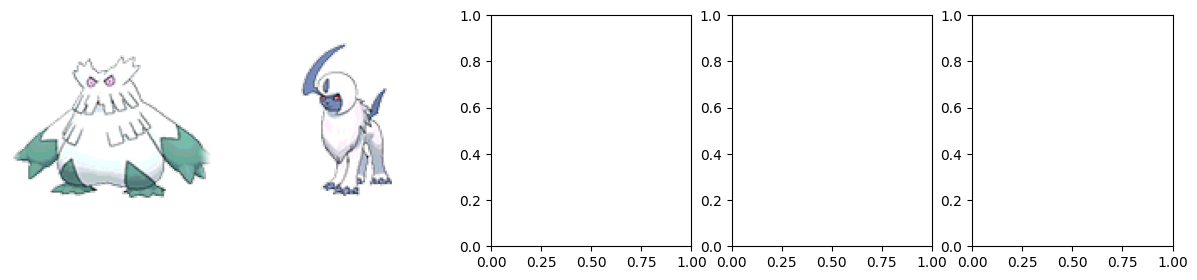

In [31]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def display_cluster_images(cluster_id, num_images=5):
    cluster_indices = np.where(clusters == cluster_id)[0][:num_images]
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(cluster_indices):
        img_path = image_files[idx]
        if os.path.exists(img_path):
            try:
                img = Image.open(img_path)
                axs[i].imshow(img)
                axs[i].axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                axs[i].axis('off')
        else:
            print(f"Image not found: {img_path}")
            axs[i].axis('off')

    plt.show()

# Display images from each cluster
for i in range(np.max(clusters) + 1):
    display_cluster_images(i)


In [18]:
import matplotlib.pyplot as plt


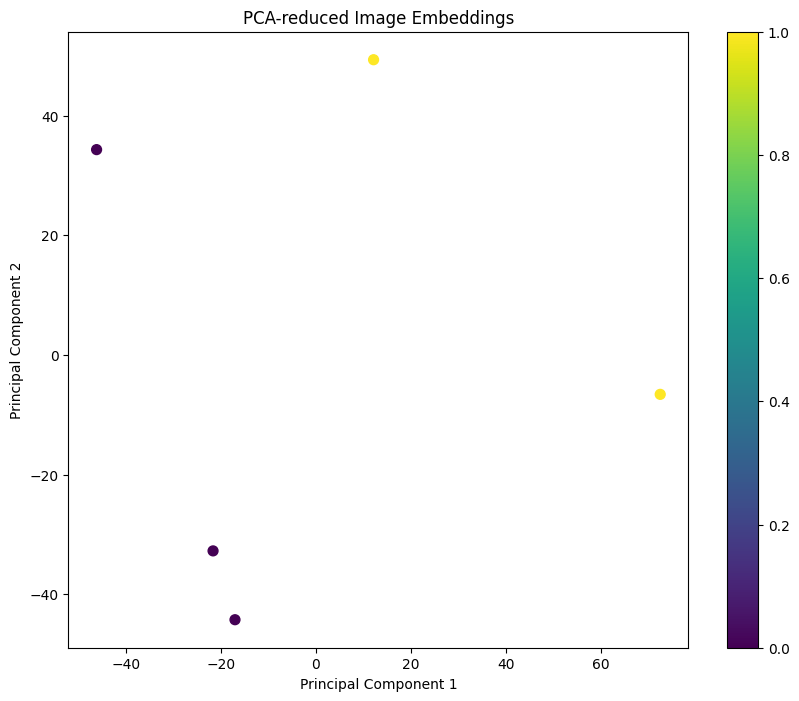

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_embeddings = pca.fit_transform(embeddings_array)

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('PCA-reduced Image Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()


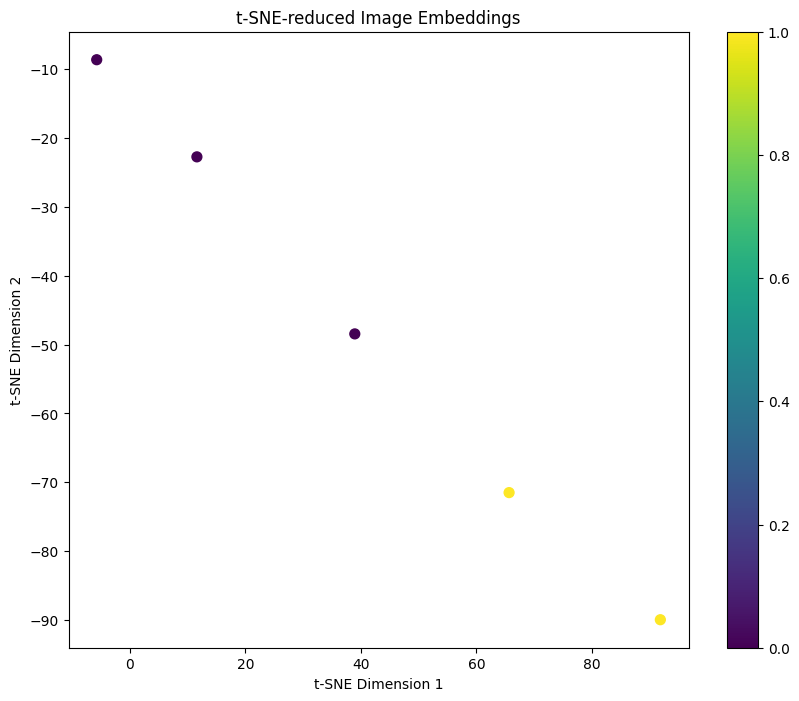

In [21]:
# Check the number of embeddings to determine a suitable perplexity value
n_samples = embeddings_array.shape[0]
perplexity_value = max(n_samples // 5, 1)  # Ensure perplexity isn't set to 0

# Initialize and fit t-SNE with the new perplexity value
tsne = TSNE(n_components=2, perplexity=perplexity_value, n_iter=300)
tsne_embeddings = tsne.fit_transform(embeddings_array)

# Plot the t-SNE-reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('t-SNE-reduced Image Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()

